In [7]:
import xgboost
import shap
import pandas as pd
import numpy as np

In [8]:
# load JS visualization code to notebook
shap.initjs()

In [9]:
# read the data
df = pd.read_csv("../data/total_dry.csv", index_col=0)
df = df.head(550000)

In [10]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [11]:
# convert all columns of DataFrame
df = df.dropna()

In [12]:
df = df.apply(pd.to_numeric)

In [19]:
df.shape

(549998, 89)

In [14]:
array = df.values
cols = [col for col in df.columns if col not in ['mean_commits']]
X = df[cols]
y = df['mean_commits']

In [15]:
# train XGBoost model
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

/home/geanderson/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/geanderson/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [16]:
# explain the model's predictions using SHAP values.
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

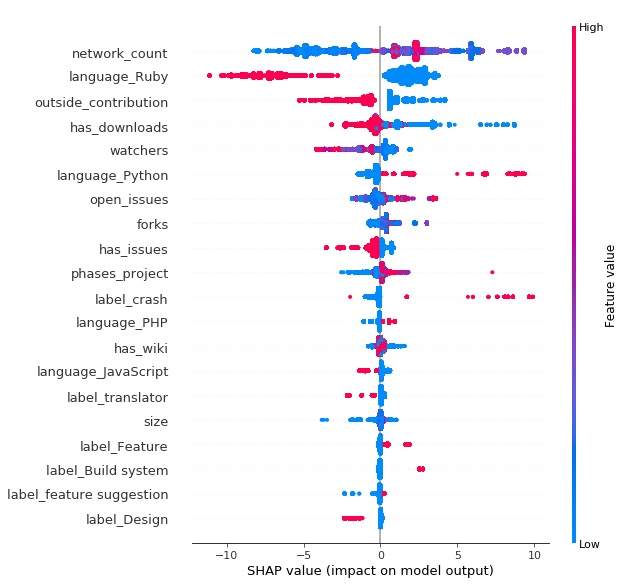

In [17]:
shap.summary_plot(shap_values, X)

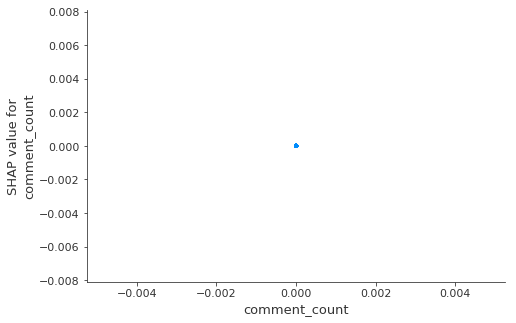

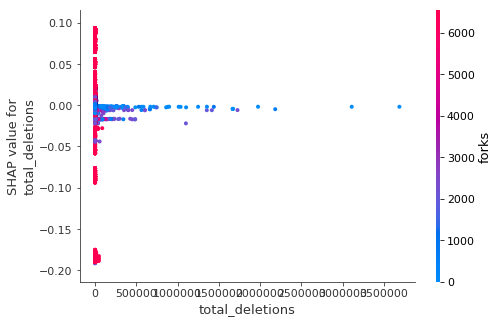

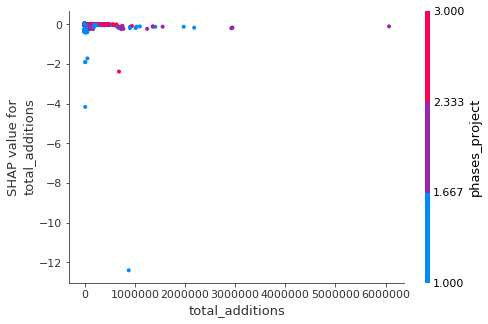

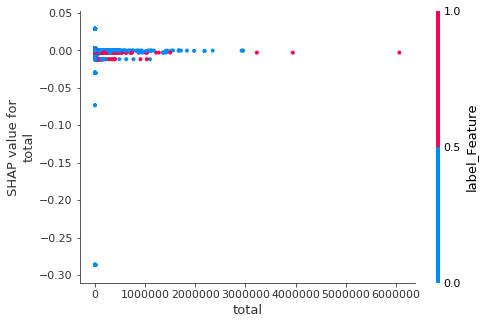

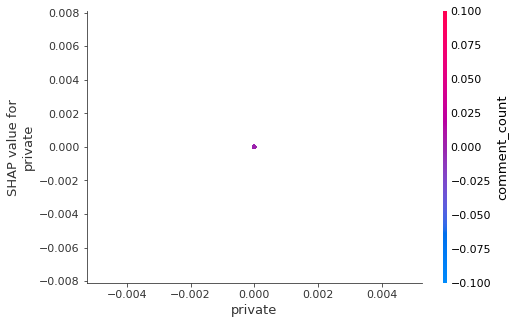

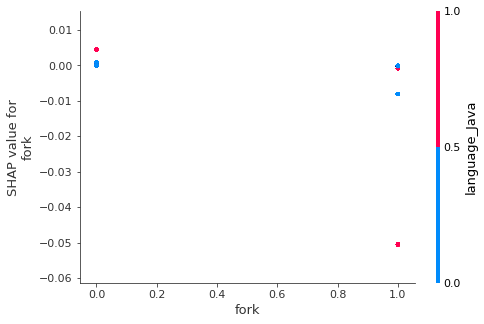

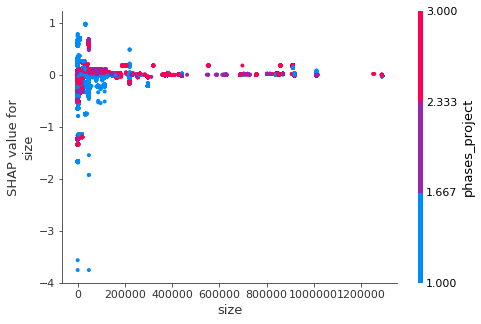

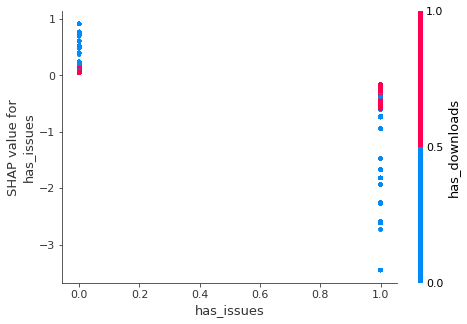

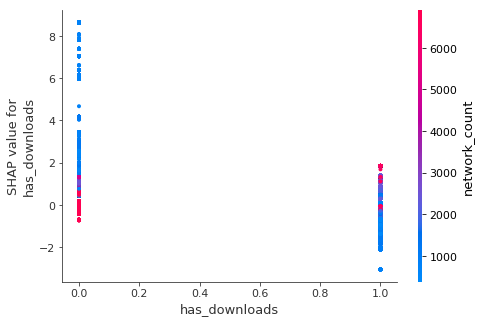

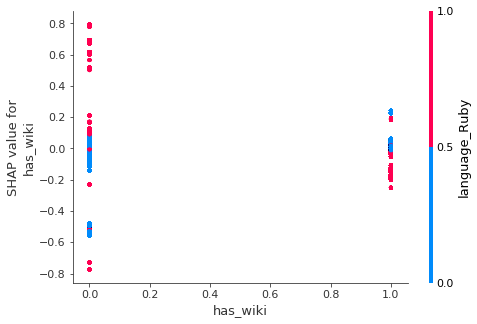

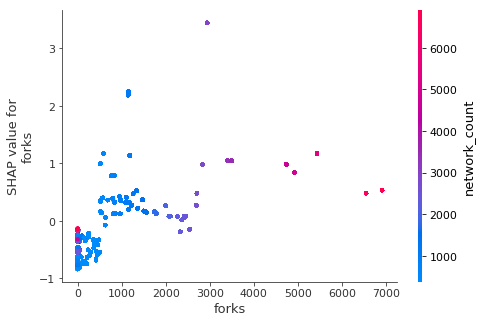

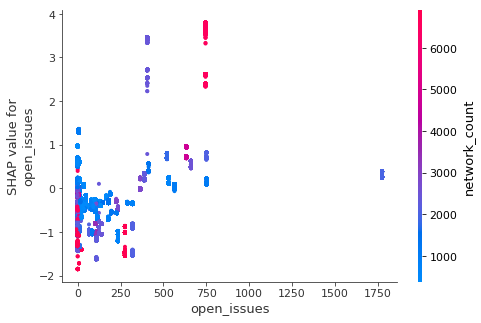

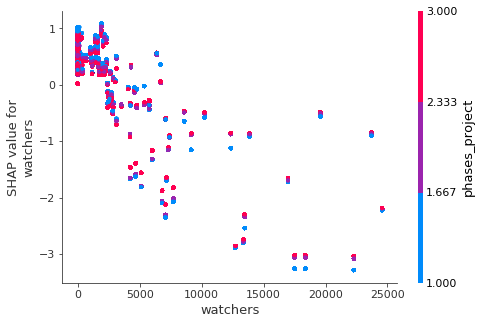

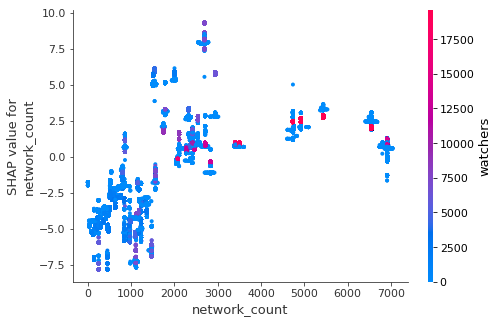

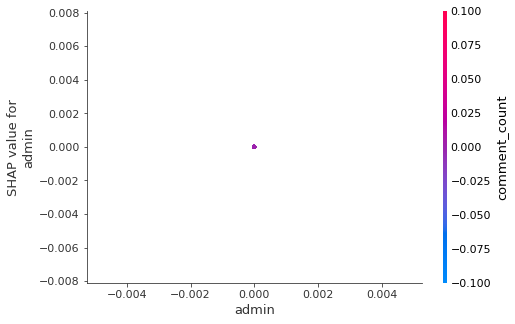

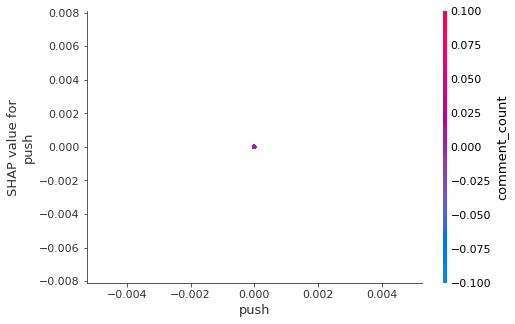

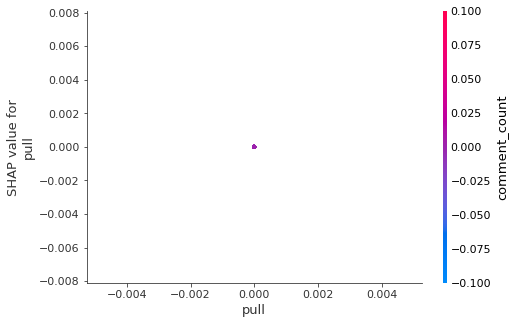

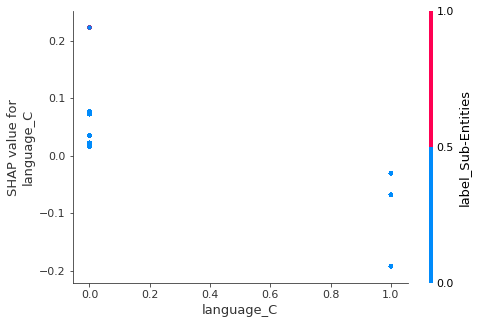

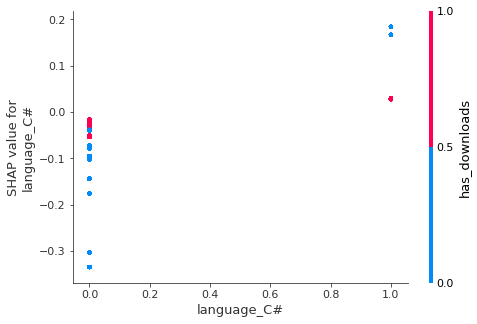

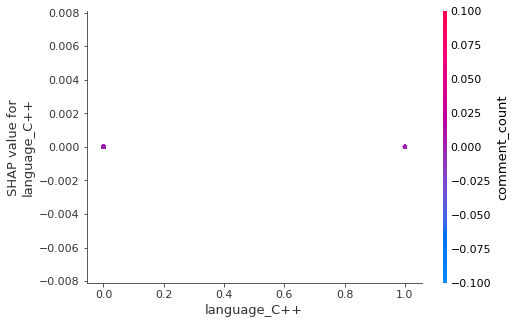

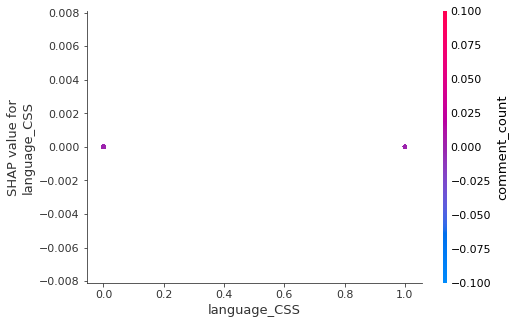

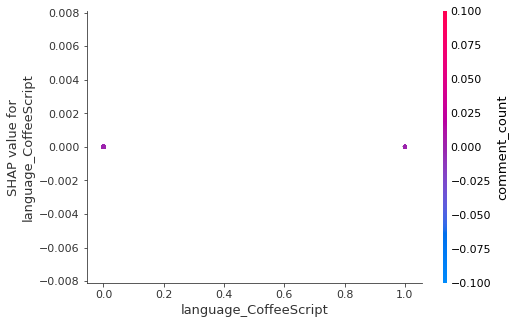

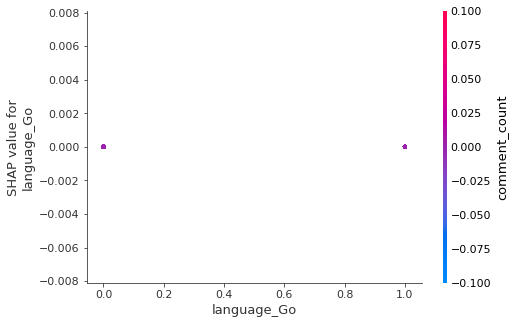

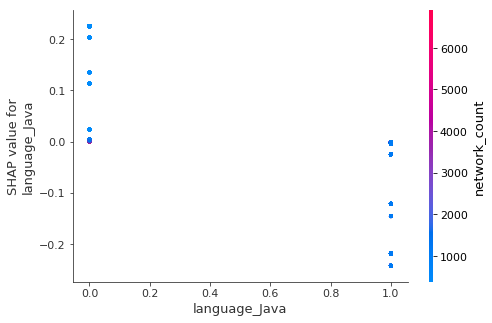

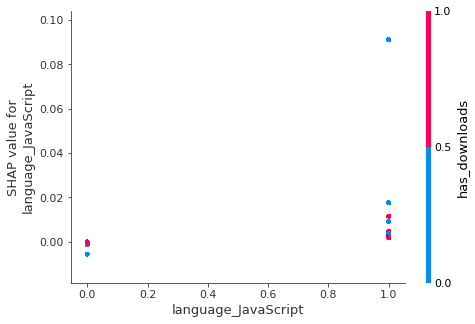

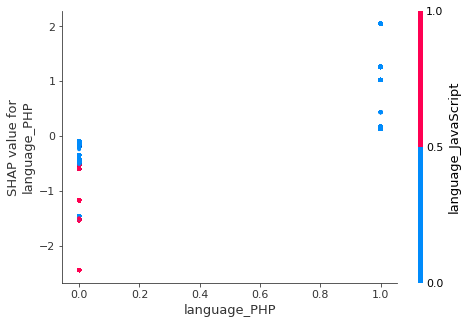

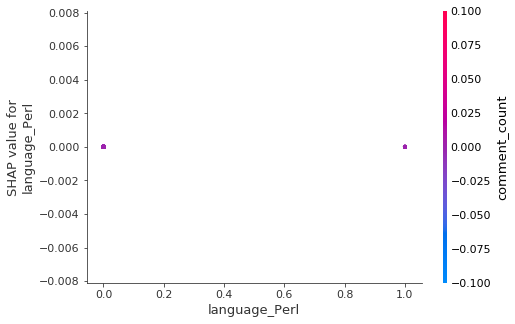

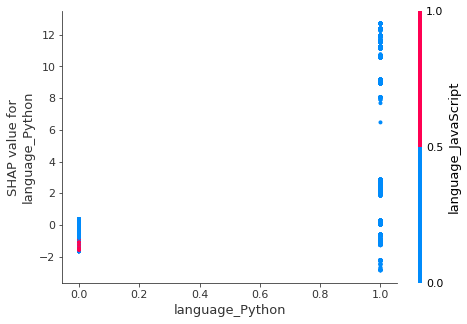

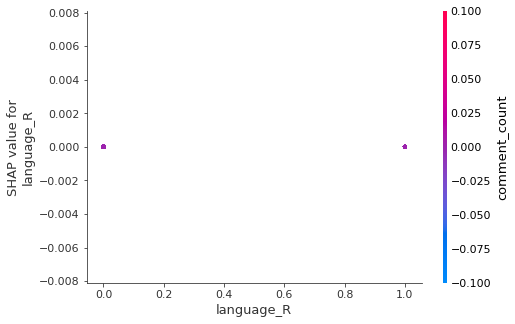

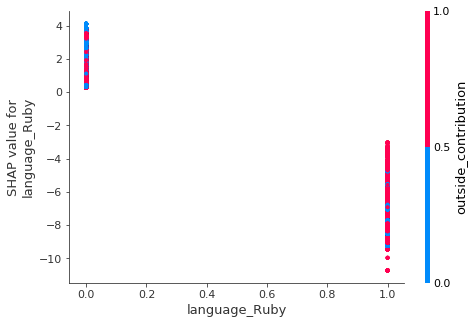

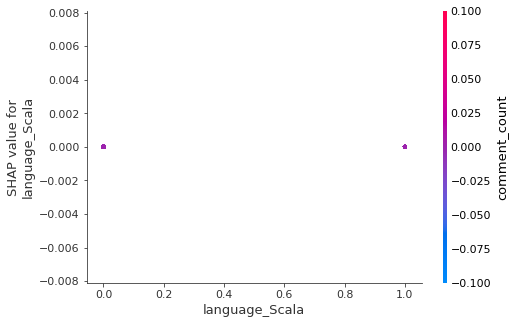

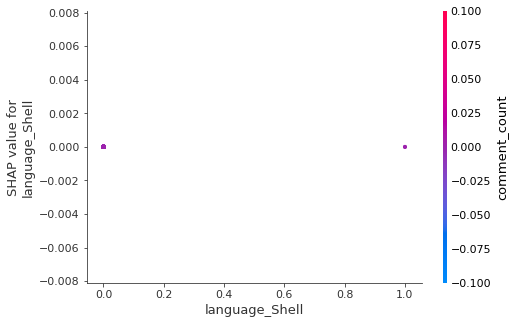

KeyboardInterrupt: 

In [26]:
# visualize the first prediction's explanation
for col in df.columns:
    if col not in ['mean_commits']:
        shap.dependence_plot(col, shap_values, X)

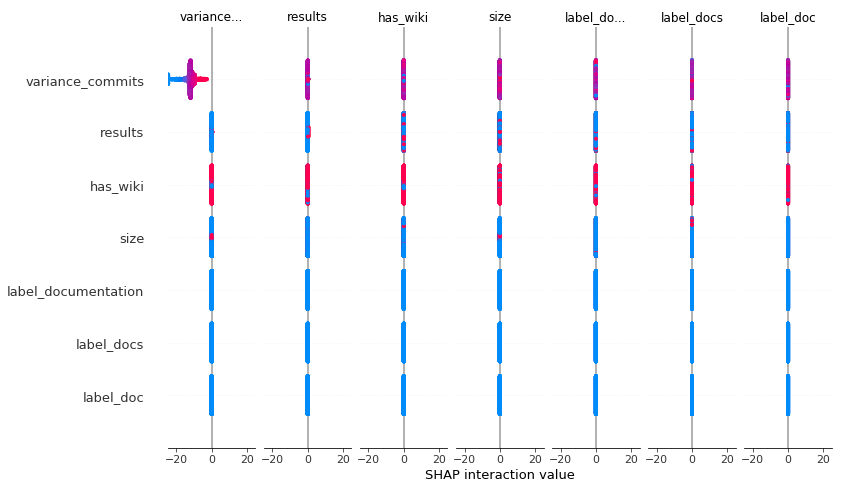

In [36]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X.iloc[:2000,:])
shap.summary_plot(shap_interaction_values, X.iloc[:2000,:])

In [37]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

/home/geanderson/anaconda3/lib/python3.7/site-packages/shap/plots/force.py:141: UserWarning: shap.force_plot is slow for many thousands of rows, try subsampling your data.
  warnings.warn("shap.force_plot is slow for many thousands of rows, try subsampling your data.")


MemoryError: 

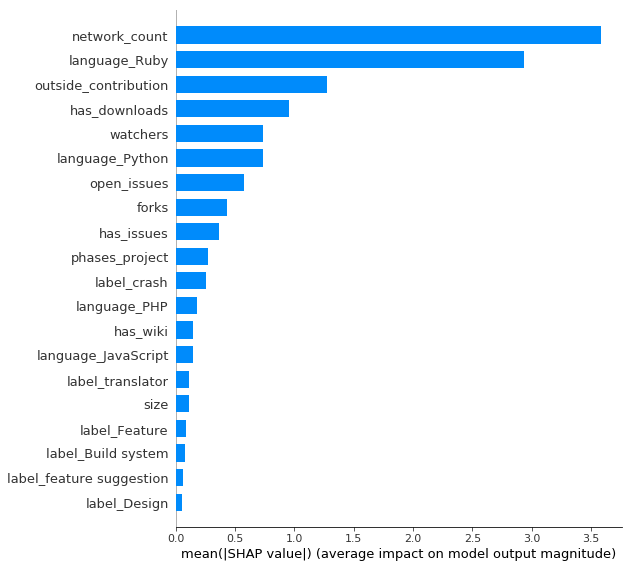

In [13]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [14]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
13,network_count,3.58535
30,language_Ruby,2.94044
79,outside_contribution,1.27787
8,has_downloads,0.952937
12,watchers,0.738228
28,language_Python,0.737739
11,open_issues,0.571327
10,forks,0.429029
7,has_issues,0.365495
86,phases_project,0.269008
